# SVM을 사용한 얼굴 검출

In [4]:
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
import numpy as np

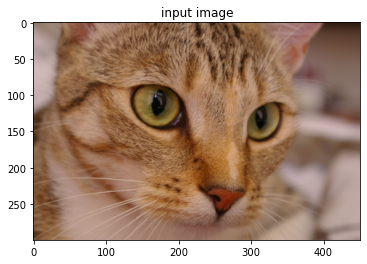

In [44]:
image = data.chelsea()
plt.imshow(image)
plt.title('input image')
plt.show()

Text(0.5, 1.0, 'Visualization of HOG features')

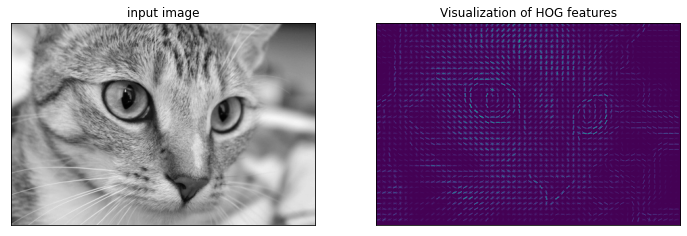

In [45]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), 
                      subplot_kw = dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('Visualization of HOG features')

In [46]:
# 안면 인식 알고리즘 구현: linear SVM 사용

In [47]:
# 얼굴 데이터 다운로드
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()

In [48]:
#1. 긍정 훈련 표본

positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [49]:
print(images[faces.target_names == 'Donald Trump'])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 5749

In [29]:
'Donald Trump' in faces.target_names

True

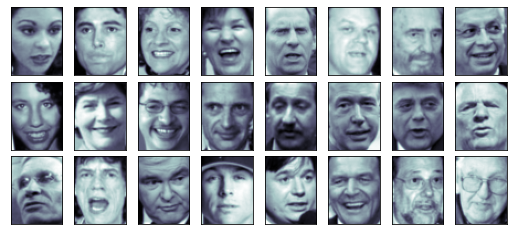

In [36]:
skip = 500
fig, axes = plt.subplots(3,8, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))                    
for i, ax in enumerate(axes.flat):
    ax.imshow(positive_patches[i+skip], cmap='bone')
plt.show()

10


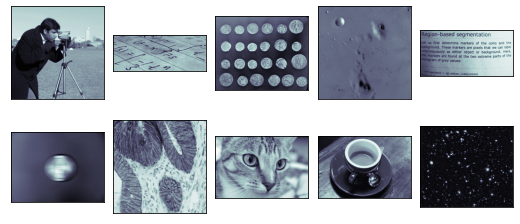

In [63]:
#2. 부정 훈련 표본
from skimage import data, transform
images_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry', 
               'chelsea', 'coffee', 'hubble_deep_field']

images = [getattr(data, name)() for name in images_to_use[:6]]
images = images + [color.rgb2gray(getattr(data, name)())
          for name in images_to_use[6:]]
print(len(images))

fig, axes = plt.subplots(2,5, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))                    
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='bone')
plt.show()

In [69]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                              max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                           for patch in patches])
    return patches


negative_patches = np.vstack([extract_patches(im, 1000, scale)
                            for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

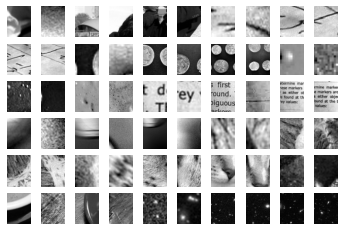

In [75]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500*i], cmap='gray')
    axi.axis('off')

In [76]:
# 집합을 결합하고 HOG 특징 추출
from itertools import chain

X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [77]:
X_train.shape

(43233, 1215)

In [78]:
# Naive Bayes 의 얼굴 분류 성능
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94784318, 0.97143518, 0.97224471, 0.97501735, 0.97374508])

In [79]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ai47\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

0.9885735235252386

In [81]:
grid.best_params_

{'C': 1.0}

In [82]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

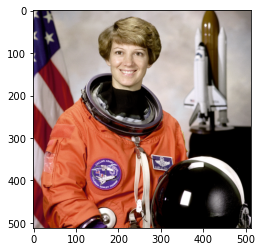

In [84]:
test_image = skimage.data.astronaut()
plt.imshow(test_image)

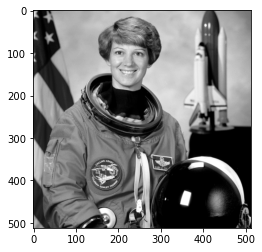

In [85]:
test_image = skimage.color.rgb2gray(test_image)
plt.imshow(test_image, cmap='gray')

(-0.5, 139.5, 159.5, -0.5)

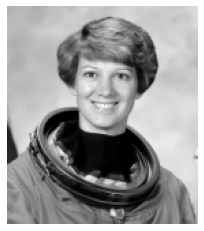

In [86]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [87]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):  #Ni
        for j in range(0, img.shape[1] - Nj, jstep): #Nj
            patch = img[i:i+Ni, j:j+Nj]
            if scale != 1:
                patch = transformation.resize(patch, patch_size)
            yield(i, j), patch

In [88]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [89]:
labels = model.predict(patches_hog)
labels.sum()

48.0

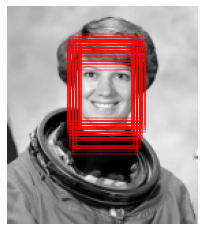

In [94]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
idxList=[]
for i, j in indices[labels==1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red',
                              alpha=0.3, lw=2, facecolor='none'))
    idxList.append([i, j])

In [95]:
print(idxList)

[[20, 52], [22, 46], [22, 48], [22, 50], [22, 52], [24, 44], [24, 46], [24, 48], [24, 50], [24, 52], [24, 54], [26, 44], [26, 46], [26, 48], [26, 50], [26, 52], [26, 54], [28, 44], [28, 46], [28, 48], [28, 50], [28, 52], [28, 54], [30, 44], [30, 46], [30, 48], [30, 50], [30, 52], [30, 54], [32, 44], [32, 46], [32, 48], [32, 50], [32, 52], [34, 46], [34, 48], [34, 50], [34, 52], [36, 48], [36, 50], [40, 46], [40, 48], [40, 50], [42, 46], [42, 48], [42, 50], [44, 48], [46, 48]]


In [96]:
idx = np.array(idxList)

In [97]:
idx.mean(axis=0)

array([30.41666667, 48.79166667])

In [98]:
idx.mean(axis=0).astype(int)

array([30, 48])

In [99]:
i, j = idx.mean(axis=0).astype(int)
i, j

(30, 48)

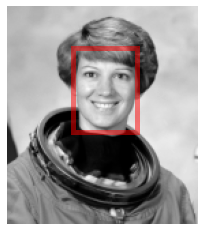

In [102]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor = 'red', alpha=0.5, lw=5, facecolor='none'))

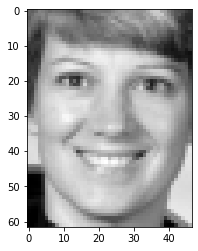

In [100]:
plt.imshow(test_image[i:i+Ni, j:j+Nj], cmap='gray')
plt.show()